In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from geopy.distance import geodesic

from sklearn import linear_model, model_selection

In [2]:
# load train and test data

# train set
df_mess_train = pd.read_csv('mess_train_list.csv')

# test set
df_mess_test = pd.read_csv('mess_test_list.csv')

# position associated to train set
pos_train = pd.read_csv('pos_train_list.csv') 

In [3]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [4]:
print(df_mess_train.shape)
df_mess_train.describe()

(39250, 8)


,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [5]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [6]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


In [7]:
# determine all Base stations that received at least 1 message
trainBs  = np.unique(df_mess_train['bsid'])
testBs   = np.unique(df_mess_test['bsid'])
listOfBs = np.union1d(trainBs, testBs) 
testOnlyBs = np.lib.arraysetops.setdiff1d(testBs, trainBs)

print(f"Number of stations: %d, test only %d" % (len(listOfBs), len(testOnlyBs)))

Number of stations: 259, test only 8


In [8]:
df_mess_train['did'].unique().shape

(113,)

In [31]:
# Feature Matrix construction 
def feat_mat_const(df_mess, listOfBs):
    df = df_mess
    df['active'] = 1
    # Add extra rows for Basestations that are not present in this dataset
    usedBs = np.unique(df['bsid'])
    missingBs = np.lib.arraysetops.setdiff1d(listOfBs, usedBs)
    df2 = pd.DataFrame([['-1', bs, 0, 0, 0, 0, 0, 0, 0] for bs in missingBs], columns=df.columns)
    df = df.append(df2)
    #df = df[df['bs_lat'] < 50]
    df = df.pivot_table(index='messid', 
                                    values=['active', 'nseq', 'rssi', 'bs_lat', 'bs_lng'], 
                                    columns=['bsid'],
                                    fill_value=0)
    resDf = df.reorder_levels([1, 0], axis=1).sort_index(level=0, axis=1)
    return resDf.drop(['-1'])

In [10]:
# ground truth construction
def ground_truth_const(df_mess_train, pos_train):
    
    df = pd.concat([df_mess_train[['messid', 'bs_lat']], pos_train], axis=1)
    df_mean = df.groupby('messid').mean()

    return df_mean['lat'], df_mean['lng']

In [32]:
df_feat = feat_mat_const(df_mess_train, listOfBs)
df_feat.head()

bsid                      879                            911                  \
                         active bs_lat bs_lng nseq rssi active bs_lat bs_lng   
messid                                                                         
573bf1d9864fce1a9af8c5c9      0    0.0    0.0    0  0.0      0    0.0    0.0   
573bf3533e952e19126b256a      0    0.0    0.0    0  0.0      0    0.0    0.0   
573c0cd0f0fe6e735a699b93      0    0.0    0.0    0  0.0      0    0.0    0.0   
573c1272f0fe6e735a6cb8bd      0    0.0    0.0    0  0.0      0    0.0    0.0   
573c8ea8864fce1a9a5fbf7a      0    0.0    0.0    0  0.0      0    0.0    0.0   

bsid                                ...  11007                          11951  \
                         nseq rssi  ... active bs_lat bs_lng nseq rssi active   
messid                              ...                                         
573bf1d9864fce1a9af8c5c9    0    0  ...      0    0.0    0.0  0.0  0.0      0   
573bf3533e952e19126b256a    0    0  ...      0    0.0    0.0  0.0  0.0      0   
573c0cd0f0fe6e735a699b93    0    0  ...      0    0.0    0.0  0.0  0.0      0   
573c1272f0fe6e735a6cb8bd    0    0  ...      0    0.0    0.0  0.0  0.0      0   
573c8ea8864fce1a9a5fbf7a    0    0  ...      0    0.0    0.0  0.0  0.0      0   

bsid                                              
                         bs_lat bs_lng nseq rssi  
messid                                            
573bf1d9864fce1a9af8c5c9    0.0    0.0    0    0  
573bf3533e952e19126b256a    0.0    0.0    0    0  
573c0cd0f0fe6e735a699b93    0.0    0.0    0    0  
573c1272f0fe6e735a6cb8bd    0.0    0.0    0    0  
573c8ea8864fce1a9a5fbf7a    0.0    0.0    0    0  

[5 rows x 1295 columns]

In [35]:
df_feat.shape

(6068, 1295)

In [36]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

## Make regressor and prediction using the train set

In [37]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat);
    reg = linear_model.LinearRegression()

    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 
    
    return y_pred_lat, y_pred_lng

In [38]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

## Cross validation

In [39]:
reg = linear_model.LinearRegression()
y_pred_lng = model_selection.cross_val_predict(reg, df_feat, ground_truth_lng, cv=5)
y_pred_lat = model_selection.cross_val_predict(reg, df_feat, ground_truth_lat, cv=5)

## Evaluate result

In [40]:
def vincenty_vec(vec_coord):
    """ Now using geodesic distance instead of Vincenty """
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] != 4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [geodesic(vec_coord[m, 0:2], vec_coord[m, 2:]).meters for m in range(vec_coord.shape[0])]

    return vin_vec_dist

In [41]:
# evaluate distance error for each predicted point
def eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

Remove asburd values of latitude and longitude

In [42]:
correct = (y_pred_lat > -90) & (y_pred_lat < 90) \
        & (y_pred_lng > -180) & (y_pred_lng <= 180)

y_pred_lat_clean = y_pred_lat[correct]
y_pred_lng_clean = y_pred_lng[correct]

ground_truth_lat_clean = ground_truth_lat[correct]
ground_truth_lng_clean = ground_truth_lng[correct]

In [43]:
err_vec = eval_geoloc(ground_truth_lat_clean, ground_truth_lng_clean, y_pred_lat_clean, y_pred_lng_clean)

## Plot error distribution

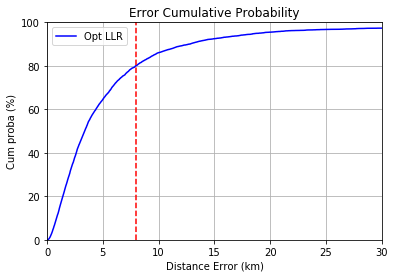

In [44]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

plt.figure()

plt.grid()

plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0,
         label="Opt LLR", c='blue')

# plot error @ 80%
plt.axvline(x=np.percentile(err_vec, 80)/1000., ymin=0, ymax=100,
            linestyle='dashed', color='red')

plt.xlabel('Distance Error (km)')
plt.ylabel('Cum proba (%)')
plt.axis([0, 30, 0, 100]) 

plt.title('Error Cumulative Probability')
plt.legend()

plt.show()

## Error criterion

In [45]:
print(f"error @ 80% = {np.percentile(err_vec, 80):.1f} m")

error @ 80% = 7953.2 m


## Construct test prediction

In [46]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [47]:
df_feat_test = feat_mat_const(df_mess_test, listOfBs)
df_feat.shape, df_feat_test.shape

((6068, 1295), (5294, 1295))

In [48]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

In [54]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res = pd.concat([df_mess_test['messid'], test_res], axis=1)

In [56]:
test_res.head()

,messid,lat,lng
0,573be2503e952e191262c351,39.777944,-105.066282
1,573c05f83e952e1912758013,39.762326,-105.048253
2,573c05f83e952e1912758013,39.701267,-105.014141
3,573c05f83e952e1912758013,39.774369,-105.042103
4,573c05f83e952e1912758013,39.682592,-105.007466


In [57]:
test_res.to_csv('pred_pos_test_list.csv', index=False)